# Loading and Checking Data

## Importing Libraries

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
use_cuda = torch.cuda.is_available()

## Loading Data

In [3]:
batch_size = 4

# These are the mean and standard deviation values for all pictures in the training set.
mean = (0.4914 ,  0.48216,  0.44653)
std = (0.24703,  0.24349,  0.26159)

# Class to denormalize images to display later.
class DeNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

# Creating instance of Functor
denorm = DeNormalize(mean, std)

# Load data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# Do NOT shuffle the test set or else the order will be messed up
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

# Classes in order
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Sample Images and Labels

 bird   cat  ship truck


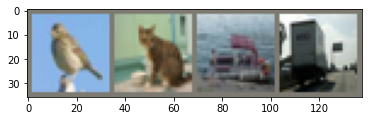

In [4]:
# functions to show an image
def imshow(img):
    img = denorm(img)    # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# Defining Model

## Fully-Connected DNN

In [5]:
class Net_DNN(nn.Module):
    def __init__(self, architecture):
        super().__init__()
        self.layers = nn.ModuleList([
                                    nn.Linear(architecture[layer], architecture[layer + 1]) 
                                    for layer in range(len(architecture) - 1)])
        
    def forward(self, data):
        # Flatten the Tensor (i.e., dimensions 3 x 32 x 32) to a single column
        data = data.view(data.size(0), -1)
        for layer in self.layers:
            layer_data = layer(data)
            data = F.relu(layer_data)
        return F.log_softmax(layer_data, dim=-1)

## Fully-CNN

In [6]:
class Net_CNN(nn.Module):
    # Padding is set to 2 and stride to 2
    # Padding ensures all edge pixels are exposed to the filter
    # Stride = 2 is common practice
    def __init__(self, layers, c, stride=2):
        super().__init__()
        self.layers = nn.ModuleList([
                                    nn.Conv2d(layers[i], layers[i + 1], kernel_size=3, padding=2, stride=stride)
                                    for i in range(len(layers) - 1)])
        self.pool = nn.AdaptiveMaxPool2d(1) # Simply takes the maximum value from the Tensor
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, data):
        for layer in self.layers: 
            data = F.relu(layer(data))
        data = self.pool(data)
        data = data.view(data.size(0), -1)
        return F.log_softmax(self.out(data), dim=-1)

## Chained CNN and NN

In [7]:
class Net_CNN_NN(nn.Module):
    # Padding is set to 2 and stride to 2
    # Padding ensures all edge pixels are exposed to the filter
    # Stride = 2 is common practice
    def __init__(self, layers, architecture, stride=2):
        super().__init__()
        # Fully Convolutional Layers
        self.layers = nn.ModuleList([
                                    nn.Conv2d(layers[i], layers[i + 1], kernel_size=3, padding=2,stride=stride)
                                    for i in range(len(layers) - 1)])
        # Fully Connected Neural Network to map to output
        self.layers_NN = nn.ModuleList([
                                    nn.Linear(architecture[layer], architecture[layer + 1]) 
                                    for layer in range(len(architecture) - 1)])
        
        self.pool = nn.AdaptiveMaxPool2d(1) # Simply takes the maximum value from the Tensor
        
    def forward(self, data):
        for layer in self.layers: 
            data = F.relu(layer(data))
        data = self.pool(data)
        data = data.view(data.size(0), -1)
        for layer in self.layers_NN:
            layer_data = layer(data)
            data = F.relu(layer_data)
        
        return F.log_softmax(layer_data, dim=-1)

## Defining the NN, Loss Function and Optimizer

In [8]:
# ---------------------------------------------
# Uncomment the architecture you want to use
# ---------------------------------------------

# # DNN
architecture = [32*32*3, 400, 400, 400, 400, 10]
net = Net_DNN(architecture)

# # CNN
# architecture = [3, 20, 40, 80, 160]
# num_outputs = 10
# net = Net_CNN(architecture, num_outputs)

# # CNN with NN
# architecture = [3, 20, 40, 80]
# architecture_NN = [80, 40, 20, 10]
# num_outputs = 10
# net = Net_CNN_NN(architecture, architecture_NN)

if use_cuda:
    net = net.cuda() # Training on the GPU

criterion = nn.CrossEntropyLoss()

## Loading Model

In [9]:
# ---------------------------------------------
# Uncomment the architecture you want to use
# ---------------------------------------------

# # DNN
#architecture = [32*32*3, 100, 100, 10]
#net = Net_DNN(architecture)

# # CNN
'''architecture = [3, 20, 40, 80, 160]
num_outputs = 10
net = Net_CNN(architecture, num_outputs)'''
criterion = nn.CrossEntropyLoss()

if use_cuda:
    net = net.cuda() # Training on the GPU

# ---------------------------------------------
# Uetermine the path for the saved weights
# ---------------------------------------------
PATH = './checkpoints_CNN_v2/5'
# Load weights
#net.load_state_dict(torch.load(PATH))

## Recording Loss

In [10]:
# Initialize a list of loss_results
loss_results = []

In [11]:
def compute_train_accuracy():
  # Determine train accuracy
  correct = 0
  total = 0
  for data in trainloader:
      # load images
      images, labels = data
      if use_cuda:
          images, labels = images.cuda(), labels.cuda()
      # feed forward
      outputs = net(Variable(images))
      # perform softmax regression
      _, predicted = torch.max(outputs.data, 1)
      # update stats
      total += labels.size(0)
      correct += (predicted == labels).sum()
  return 100*correct/total


def compute_test_accuracy():
  # Determine test accuracy
  correct = 0
  total = 0
  for data in testloader:
      # load images
      images, labels = data
      if use_cuda:
          images, labels = images.cuda(), labels.cuda()
      # feed forward
      outputs = net(Variable(images))
      # perform softmax regression
      _, predicted = torch.max(outputs.data, 1)
      # update stats
      total += labels.size(0)
      correct += (predicted == labels).sum()
  return 100*correct/total

# Training Manual

In [12]:
# Set the Learning rate and epoch start and end points
start_epoch = 1
end_epoch = 15
lr = 0.0001
# Define the optimizer
#optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=lr)

train_accuracies = [] # Keep track of training and test accuracies for plots
test_accuracies = []

for epoch in range(start_epoch, end_epoch+1):  # loop over the dataset multiple times
    print("Epoch:", epoch)
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader, 0):
        # get the inputs
        if use_cuda:
            inputs, labels = inputs.cuda(), labels.cuda()

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels) # Inputs and Target values to GPU

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(running_loss / 2000)
            loss_results.append(running_loss / 2000)
            running_loss = 0.0
    PATH = './checkpoints_hybrid/' + str(epoch)
    import os
    os.makedirs('./checkpoints_hybrid', exist_ok=True)
    torch.save(net.state_dict(), PATH)
    train_acc = compute_train_accuracy()
    test_acc = compute_test_accuracy()
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    print('Accuracy of the network on the 50000 train images: %d %%' % (train_acc))
    print('Accuracy of the network on the 10000 test images: %d %%' % (test_acc))
        

Epoch: 1
1.8684152770638467
1.6970490334481
1.6439989620149136
1.6082630559951068
1.5777587401270867
1.5275802991762757
Accuracy of the network on the 50000 train images: 50 %
Accuracy of the network on the 10000 test images: 49 %
Epoch: 2
1.4443296261951328
1.4299699961021544
1.4112969520762564
1.4072769005466252
1.4101111987158657
1.3906830924153328
Accuracy of the network on the 50000 train images: 54 %
Accuracy of the network on the 10000 test images: 49 %
Epoch: 3
1.286445750683546
1.26938028293103
1.283876324273646
1.2944891068674624
1.2717283894121647
1.290284023974091
Accuracy of the network on the 50000 train images: 60 %
Accuracy of the network on the 10000 test images: 52 %
Epoch: 4
1.162434448743239
1.169091368380934
1.1886916981972755
1.1593251050561666
1.168604845225811
1.1784651909247041
Accuracy of the network on the 50000 train images: 62 %
Accuracy of the network on the 10000 test images: 52 %
Epoch: 5
1.042392447737977
1.0602269689515234
1.0587134577725084
1.07922919

## Sample of the Results

GroundTruth:    cat  ship  ship plane


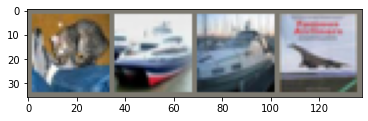

In [13]:
# load a min-batch of the images
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Sample of Predictions

In [14]:
# For the images shown above, show the predictions
# first activate GPU processing
if use_cuda:
  images, labels = images.cuda(), labels.cuda()

# Feed forward
outputs = net(Variable(images))
_, predicted = torch.max(outputs.data, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship  deer


## Total Test Set Accuracy

In [15]:
# Small code snippet to determine test accuracy
correct = 0
total = 0
for data in testloader:
    # load images
    images, labels = data
    if use_cuda:
        images, labels = images.cuda(), labels.cuda()
    # feed forward
    outputs = net(Variable(images))
    # perform softmax regression
    _, predicted = torch.max(outputs.data, 1)
    # update stats
    total += labels.size(0)
    correct += (predicted == labels).sum()

# print the results
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 53 %


## Accuracy per Class for Test Set

In [16]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    if use_cuda:
        images, labels = images.cuda(), labels.cuda()
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1

# Print the accuracy per class
for i in range(10):
    print(classes[i], 100 * class_correct[i] / class_total[i])

plane tensor(64.5000)
car tensor(65.8000)
bird tensor(38.5000)
cat tensor(40.3000)
deer tensor(47.9000)
dog tensor(38.4000)
frog tensor(63.3000)
horse tensor(58.2000)
ship tensor(62.)
truck tensor(53.7000)


# Plot Loss

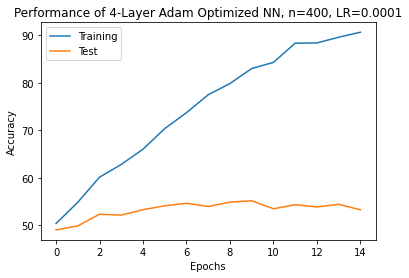

In [17]:
plt.plot(list(range(0, len(train_accuracies))), train_accuracies) # Plot both the training and test accuracies
plt.plot(list(range(0, len(test_accuracies))), test_accuracies)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Performance of 4-Layer Adam Optimized NN, n=400, LR=0.0001')
plt.legend(['Training', 'Test'])
plt.show()